<a href="https://colab.research.google.com/github/carla-biermann/uniform-solution-sampling/blob/main/experiment/notebooks/compare_gof_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
# @title Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import random
import scipy

In [3]:
# Function to apply chi-square test to each row
def chi2_test(row, k):
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)  # Assuming uniform distribution

    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed - expected)**2 / expected)

    # Calculate p-value
    p_value = 1 - scipy.stats.chi2.cdf(chi_squared_stat, df=k-1)

    return p_value

# Function to apply the freeman tukey test to each row
def freeman_tukey_test(row, k):
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)  # Assuming uniform distribution

    ft_stat = np.sum((np.sqrt(observed) + np.sqrt(observed + 1) - np.sqrt(4 * expected + 1))**2)

    # Calculate p-value

    p_value = 1 - scipy.stats.chi2.cdf(ft_stat, df=k-1)

    return p_value

# Function to apply the Kolmogorov-Smirnov test to each row
def ks_test(row, k):
    # Perform KS test
    ks_statistic, p_value = scipy.stats.ks_1samp(row, scipy.stats.randint.cdf, args=(1, k+1))
    return p_value

# Function to apply the Kolmogorov-Smirnov test to each row with the continuous uniform cdf
def ks_test_discrete(row, k):
    # Perform KS test
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)

    o_minus_e = observed - expected

    ks_statistic = max(abs(o_minus_e.cumsum()))

    # at 5 % level. Critical values from tables in [2]
    if len(row) == 20:
      critical_val = 6
    elif len(row) == 30:
      critical_val = 7
    else:
      return None

    if ks_statistic >= critical_val:
      return 0
    else:
      return 1

def cramer_von_mises_test(row, k):
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)
    n = len(row)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    Z = S - T
    W2_statistic = sum(Z**2 * (1/k)) / n
    percentage_point = 0.463 # from [1]
    if W2_statistic > percentage_point:
      return 0
    else:
      return 1

def watson_test(row, k):
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)
    n = len(row)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    Z = S - T
    Z_bar = sum(Z / k)
    U2_statistic = sum((Z - Z_bar)**2 * (1/k)) / n
    percentage_point = 0.191 # from [1]
    if U2_statistic > percentage_point:
      return 0
    else:
      return 1

def anderson_darling_test(row, k):
    observed = np.histogram(row, bins=np.arange(1, k + 2))[0]
    expected = sum(observed) / k * np.ones_like(observed)
    n = len(row)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    H = T / n
    Z = S - T
    # remove last elements as they would result in 0/0 and author sets term to 0
    Z = Z[:-1]
    H = H[:-1]
    A2_statistic = sum(Z**2 * (1/k) / (H*(1-H))) / n
    percentage_point = 2.392 # from [1]
    if A2_statistic > percentage_point:
      return 0
    else:
      return 1

# Function to get p values for different sample sizes
def get_p_values(low_limit, up_limit, step_size, tests, iterations, k):

  random.seed(5059)

  p_vals_df = pd.DataFrame(columns = ["k", "n"] + [t.__name__ for t in tests])

  # for each sample size between low_limit and up_limit with step size
  for i in range(low_limit, up_limit, step_size):

    # get iterations uniform samples of size i
    unif_sample = scipy.stats.randint.rvs(low=1, high=k+1, size=(iterations, i))

    # store new row in dict first
    p_vals_dict = dict()
    p_vals_dict["k"] = k
    p_vals_dict["n"] = i

    for test in tests:

      # apply test to uniform samples and obtain p-values
      p_vals = np.apply_along_axis(test, axis=1, arr=unif_sample, k=k)

      if not None in p_vals:

        # store percentage of significant p-values in dictionary
        p_vals_dict[test.__name__] = (p_vals < 0.05).sum() / iterations # to get percentage

    # append new row to dataframe
    p_vals_df = pd.concat([p_vals_df, pd.DataFrame([p_vals_dict])], ignore_index=True)

  return(p_vals_df)

## Compare statistical tests

based on uniform sample. See how well they do not reject H_0 then.

In [4]:
tests = [freeman_tukey_test, chi2_test, watson_test, cramer_von_mises_test, anderson_darling_test, ks_test, ks_test_discrete]

p_vals_df = get_p_values(10, 150, 10, tests, 100, 10)

In [5]:
p_vals_df

,k,n,freeman_tukey_test,chi2_test,watson_test,cramer_von_mises_test,anderson_darling_test,ks_test,ks_test_discrete
0,10,10,0.00,0.03,0.06,0.06,0.06,0.04,NaN
1,10,20,0.08,0.02,0.04,0.06,0.05,0.15,0.02
2,10,30,0.06,0.04,0.04,0.03,0.03,0.12,0.02
3,10,40,0.09,0.08,0.03,0.05,0.04,0.14,NaN
4,10,50,0.06,0.02,0.06,0.05,0.05,0.24,NaN
5,10,60,0.04,0.04,0.04,0.02,0.02,0.22,NaN
6,10,70,0.02,0.01,0.02,0.09,0.08,0.32,NaN
7,10,80,0.06,0.07,0.07,0.05,0.05,0.54,NaN
8,10,90,0.05,0.08,0.08,0.08,0.09,0.52,NaN
9,10,100,0.03,0.02,0.04,0.05,0.03,0.59,NaN


In [ ]:
#p_vals_df.to_csv('stat_test_comparison.csv')

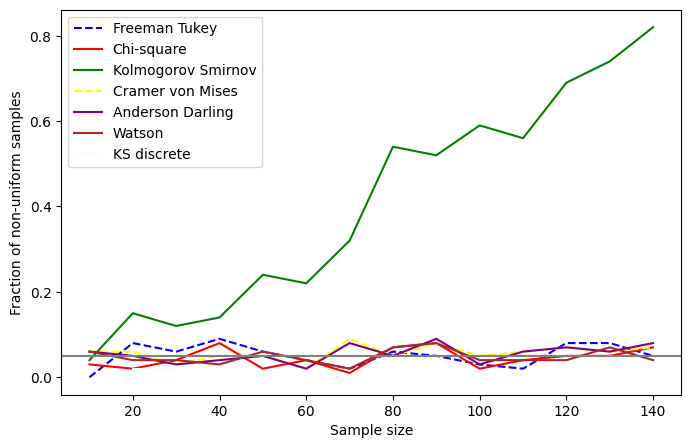

In [7]:
# @title Plot
plt.figure(figsize=(8, 5))

# Plot lines from Freeman Tukey
plt.plot(p_vals_df["n"], p_vals_df["freeman_tukey_test"], label='Freeman Tukey', color='blue', linestyle='--')

# Plot lines from Chi Square
plt.plot(p_vals_df["n"],p_vals_df["chi2_test"], label='Chi-square', color='red', linestyle='-')

# Plot lines from Kolmogorov Smirnov
plt.plot(p_vals_df["n"], p_vals_df["ks_test"], label='Kolmogorov Smirnov', color='green', linestyle='-')

# Plot lines from Cramer von Mises
plt.plot(p_vals_df["n"], p_vals_df["cramer_von_mises_test"], label='Cramer von Mises', color='yellow', linestyle='--')

# Plot lines from Anderson Darling
plt.plot(p_vals_df["n"], p_vals_df["anderson_darling_test"], label='Anderson Darling', color='purple', linestyle='-')

# Plot lines from Watson
plt.plot(p_vals_df["n"], p_vals_df["watson_test"], label='Watson', color='brown', linestyle='-')

# Plot lines from Discrete KS
plt.plot(p_vals_df["n"], p_vals_df["ks_test_discrete"], label='KS discrete', color='azure', linestyle='-')

plt.axhline(y = 0.05, color = 'grey', linestyle = '-')

# Customize the plot
plt.xlabel('Sample size')
plt.ylabel('Fraction of non-uniform samples')
plt.legend()

# Show the plot for each column
plt.show()

## References

[1] Choulakian, V., Lockhart, R. A., & Stephens, M. A. (1994). Cramér-von Mises Statistics for Discrete Distributions. The Canadian Journal of Statistics / La Revue Canadienne de Statistique, 22(1), 125–137. https://doi.org/10.2307/3315828

[2] Pettitt, A. N., & Stephens, M. A. (1977). The Kolmogorov-Smirnov Goodness-of-Fit Statistic with Discrete and Grouped Data. Technometrics, 19(2), 205–210. https://doi.org/10.2307/1268631